<a href="https://colab.research.google.com/github/Jack3690/INSIST/blob/main/PSF_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Initialization**

In [1]:
!pip install photutils --quiet

     |████████████████████████████████| 826 kB 9.7 MB/s 


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import photutils as phot
from photutils.aperture import aperture_photometry

from astropy.convolution import Gaussian2DKernel
from scipy.signal import convolve as scipy_convolve
import scipy.optimize as opt
from astropy.convolution import convolve
from matplotlib import colors
from time import perf_counter
from astropy.stats import gaussian_fwhm_to_sigma, gaussian_sigma_to_fwhm
from astropy.modeling import models, fitting
from scipy.interpolate import interp1d
from scipy import signal

matplotlib.rcParams['figure.figsize'] = (10,10)
matplotlib.rcParams['font.size']      = 15

In [3]:
import torch
import torch.nn.functional as F
from torch.autograd import Variable

In [4]:
!git clone https://github.com/Jack3690/INSIST

Cloning into 'INSIST'...
remote: Enumerating objects: 703, done.
remote: Counting objects: 100% (328/328), done.
remote: Compressing objects: 100% (324/324), done.
remote: Total 703 (delta 183), reused 4 (delta 2), pack-reused 375
Receiving objects: 100% (703/703), 78.55 MiB | 17.09 MiB/s, done.
Resolving deltas: 100% (371/371), done.


In [5]:
cd INSIST/data

/content/INSIST/data


# **Convolutions**

## **Off-axis**

In [180]:
fwhm_in     = 0.2   # arcsecs
pixel_scale = 0.01  # arcseconds/pixels
FWHM        = fwhm_in/pixel_scale
sigma       = FWHM*gaussian_fwhm_to_sigma
sigma

8.493218002880191

### **Using  PyTorch**

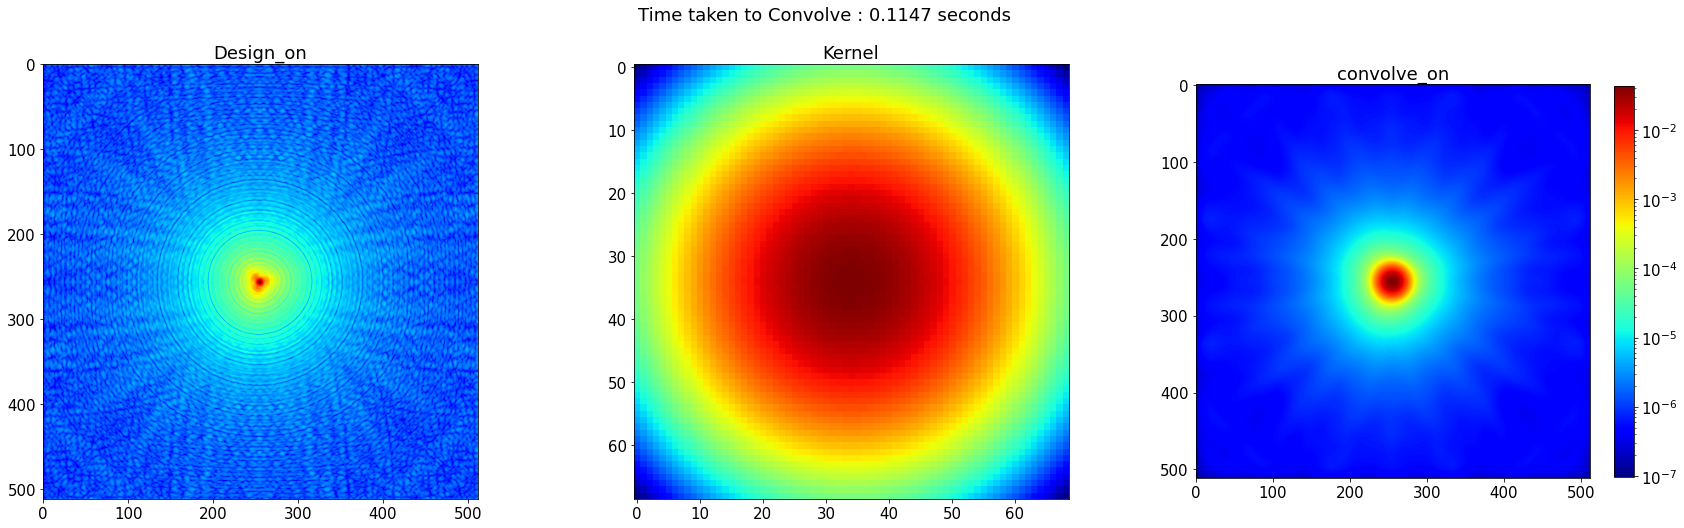

In [7]:
Off_PSF =np.loadtxt("off_axis.TXT",skiprows=18,encoding='latin-1') # Read PSF file
Off_PSF = (1*Off_PSF)/Off_PSF.max()

fig, ax = plt.subplots(1,3, figsize = (30,8))
ax[0].set_title("Design_on")
ax[0].imshow(Off_PSF, cmap="jet",norm=colors.LogNorm())

kernel = Gaussian2DKernel(sigma,sigma,x_size=69,y_size=69)
kernel.normalize()

Off_PSF_ = np.pad(Off_PSF,34,mode='constant')

data     = torch.tensor(Off_PSF_).unsqueeze(0).cuda()
kernel_t = torch.tensor(kernel.array).cuda()

start = perf_counter()
out = F.conv2d(Variable(data.view(1,1,580,580)),Variable(kernel_t.view(1,1,69,69))).squeeze().cpu().numpy()

stop  = perf_counter()- start

ax[1].set_title("Kernel")
ax[1].imshow(kernel, cmap="jet",norm=colors.LogNorm())

ax[2].set_title("convolve_on")
im_on = ax[2].imshow(out, cmap="jet",norm=colors.LogNorm())
plt.colorbar(im_on,shrink=0.9)
fig.suptitle(f"Time taken to Convolve : {np.round(stop,4)} seconds");

### **Using Astropy**

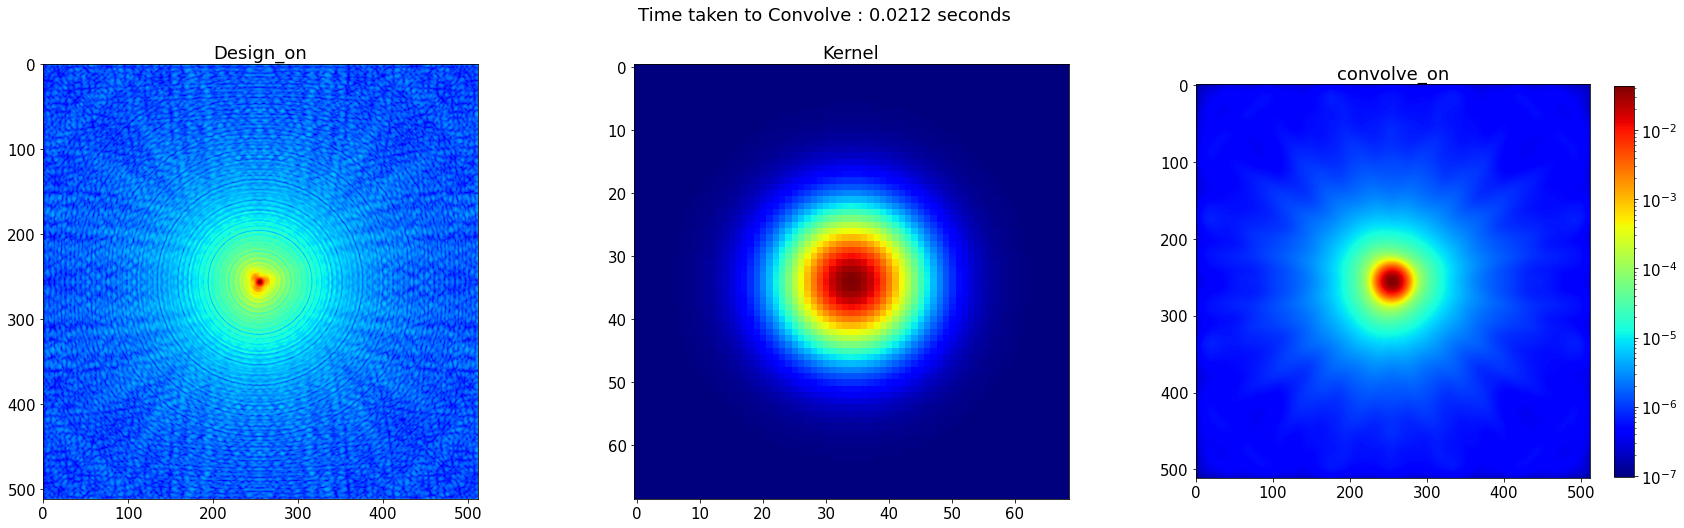

In [181]:
Off_PSF = np.loadtxt("off_axis.TXT",skiprows=18,encoding='latin-1') # Read PSF file
Off_PSF = (1*Off_PSF)/Off_PSF.max()

kernel = Gaussian2DKernel(sigma,sigma,x_size=69,y_size=69)
kernel.normalize()

fig, ax = plt.subplots(1,3, figsize = (30,8))
ax[0].set_title("Design_on")
ax[0].imshow(Off_PSF, cmap="jet",norm=colors.LogNorm())
start = perf_counter()
astropy_conv_off =  signal.fftconvolve(Off_PSF, kernel, mode="same") # convolve(Off_PSF, kernel) 


stop  = perf_counter()- start

ax[1].set_title("Kernel")
ax[1].imshow(kernel, cmap="jet")

ax[2].set_title("convolve_on")
im_on = ax[2].imshow(astropy_conv_off, cmap="jet",norm=colors.LogNorm())
plt.colorbar(im_on,shrink=0.9)
fig.suptitle(f"Time taken to Convolve : {np.round(stop,4)} seconds");

### **FWHM**

FWHM calculation using pixel to pixel distance

In [184]:
def fwhm_pixel_dist(data,r_frac_min=0.0,r_frac_max=0.01):
  flux_p  = data.max()
  i_p,j_p = np.where(data == flux_p)

  coords = []
  for i in range(data.shape[0]):
    for j in range(data.shape[0]):
      f = data[i,j]
      if f>= flux_p/2*(1 - r_frac_min) and f<=(1+ r_frac_max)*flux_p/2:
        break
    if f>= flux_p/2*(1 - r_frac_min) and f<=(1+ r_frac_max)*flux_p/2:
      coords.append([i,j,f])
  coords = np.array(coords)

  dist = np.sqrt( (i_p[0]- coords[:,0])**2 + (j_p[0]- coords[:,1])**2 )*2
  return dist , dist.mean()

In [185]:
dist, FWHM = fwhm_pixel_dist(astropy_conv_off)
FWHM

21.086042611302233

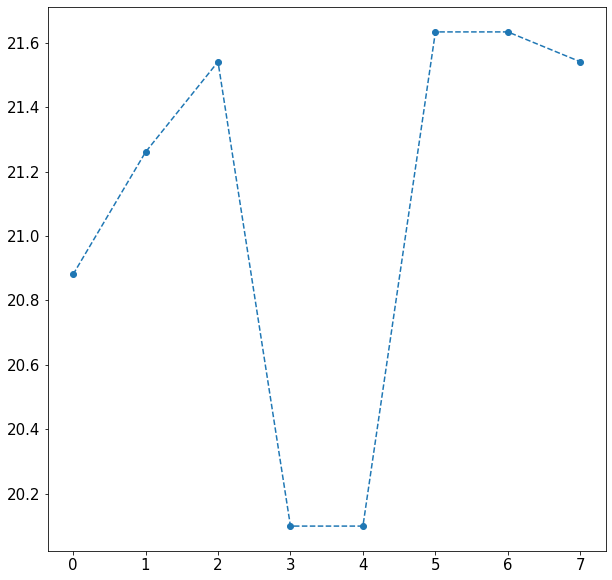

In [186]:
plt.plot(dist,'o--')

In [187]:
init = models.Gaussian2D()

fit  = fitting.LevMarLSQFitter()

y, x = np.mgrid[-256:256,-256:256]/256

model = fit(init,x,y,astropy_conv_off)
model

<Gaussian2D(amplitude=0.04347302, x_mean=-0.00549965, y_mean=0.00057359, x_stddev=0.03509108, y_stddev=0.03520674, theta=722.39958971)>

In [188]:
arr_scale = 2/512.0
arr_scale

0.00390625

In [189]:
sx = model.x_stddev.value/arr_scale
sy = model.y_stddev.value/arr_scale

In [190]:
print("FWHM_x        : {} \nFWHM_y        : {}\nPeak position : {}".format(sx*gaussian_sigma_to_fwhm, sy*gaussian_sigma_to_fwhm, np.where(astropy_conv_off==astropy_conv_off.max())))

FWHM_x        : 21.15409342683184 
FWHM_y        : 21.22381500713093
Peak position : (array([256]), array([255]))


### **Photometry**

Flux inside 3 sigma radius

In [191]:
positions              = [(256,255)]
aperture               = phot.aperture.CircularAperture(positions, r=3*sx)
data                   = astropy_conv_off
phot_table             = aperture_photometry(data, aperture)
phot_table['fraction'] = phot_table['aperture_sum']/data.sum()
phot_table

id,xcenter,ycenter,aperture_sum,fraction
,pix,pix,,
int64,float64,float64,float64,float64
1,256.0,255.0,21.958466629007738,0.9490682019107904


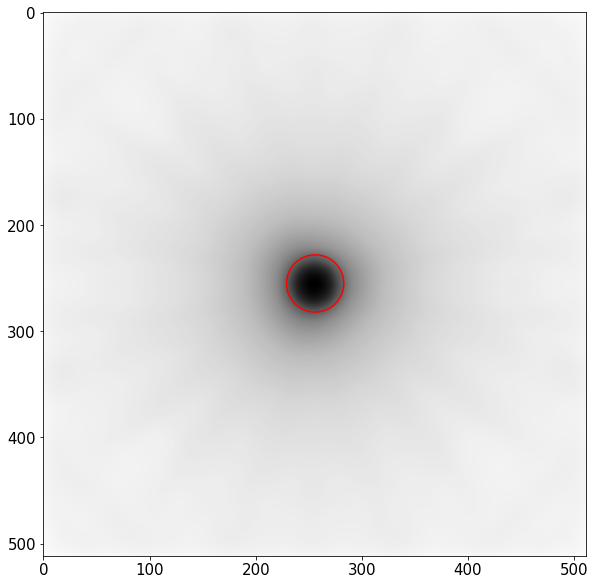

In [192]:
fig,ax = plt.subplots(1)
ax.imshow(data, cmap = 'Greys',norm=colors.LogNorm())
aperture.plot(axes=ax, color='red', lw=1.5)

In [193]:
positions   = [(256,255)]
n           = 15
aperture    = [phot.aperture.CircularAperture(positions, r=sx+sx*i) for i in range(n)]
data_off    = astropy_conv_off/astropy_conv_off.sum()
phot_table  = aperture_photometry(data_off, aperture)
phot_table

id,xcenter,ycenter,aperture_sum_0,aperture_sum_1,aperture_sum_2,aperture_sum_3,aperture_sum_4,aperture_sum_5,aperture_sum_6,aperture_sum_7,aperture_sum_8,aperture_sum_9,aperture_sum_10,aperture_sum_11,aperture_sum_12,aperture_sum_13,aperture_sum_14
,pix,pix,,,,,,,,,,,,,,,
int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
1,256.0,255.0,0.36991540738717665,0.8176512846873201,0.9490682019107903,0.9714067891590282,0.9784623561541834,0.9825370728167369,0.9852951789651463,0.9873079550511941,0.9888529286802408,0.9900855286517398,0.9910977490034114,0.9919469836910814,0.9926750654484797,0.9933152042853625,0.9938905267903608


In [194]:
flux_off = [phot_table[f'aperture_sum_{i}'].value[0] for i in range(15)]
sigma = [i for i in range(1,1+n)]

Text(0, 0.5, 'Flux')

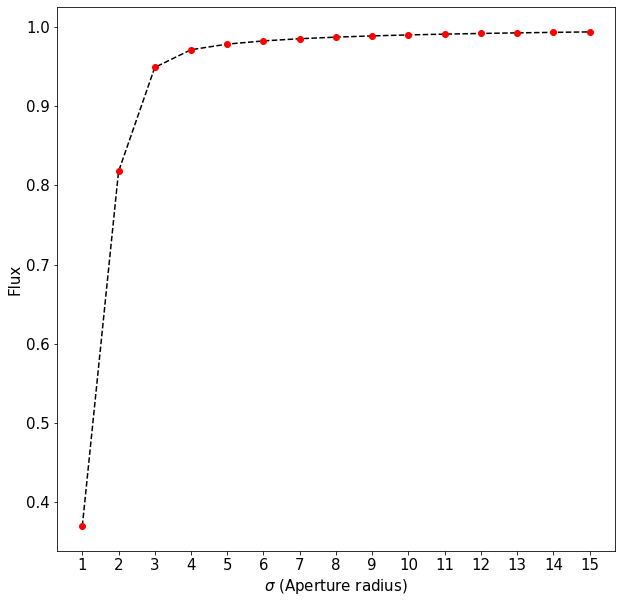

In [195]:
plt.plot(sigma,flux_off, markeredgecolor='red',markerfacecolor='red',color='black', marker='o', linestyle='dashed')
plt.xticks(sigma)
plt.xlabel(r'$\sigma$ (Aperture radius)')
plt.ylabel('Flux')

In [196]:
cen_i, cen_j = np.where(data_off == data_off.max())
cen_i, cen_j = cen_i[0], cen_j[0]

In [197]:
data_off.max()

0.001892698433896608

In [198]:
off_esf = []
off_x   = np.arange(0,100,1)
for i in off_x:
  fl = data_off[cen_i-i:cen_i + i+1,cen_j-i:cen_j+i+1]
  off_esf.append(fl.sum())

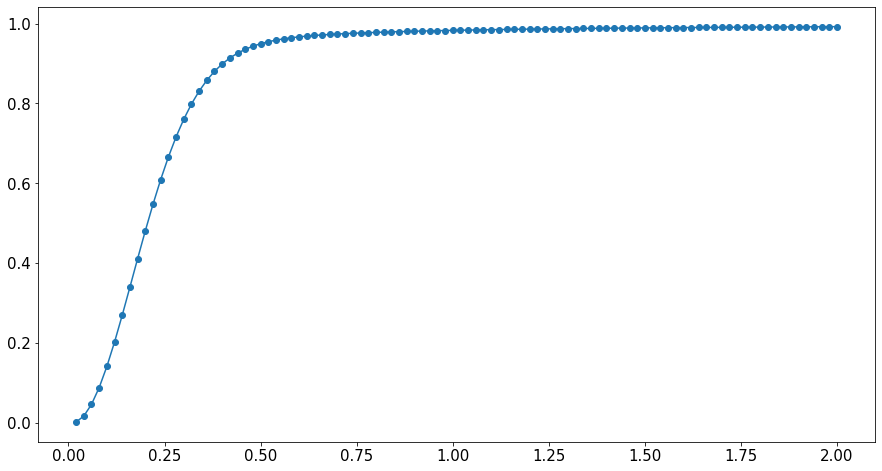

In [199]:
plt.figure(figsize=(15,8))
plt.plot(off_x*0.02+0.02,off_esf,'o-')

## **On-axis**

In [200]:
fwhm_in     = 0.2 # arcsecs
pixel_scale = 0.01
FWHM        = fwhm_in/pixel_scale
sigma       = FWHM*gaussian_fwhm_to_sigma
sigma

8.493218002880191

### **Using PyTorch**

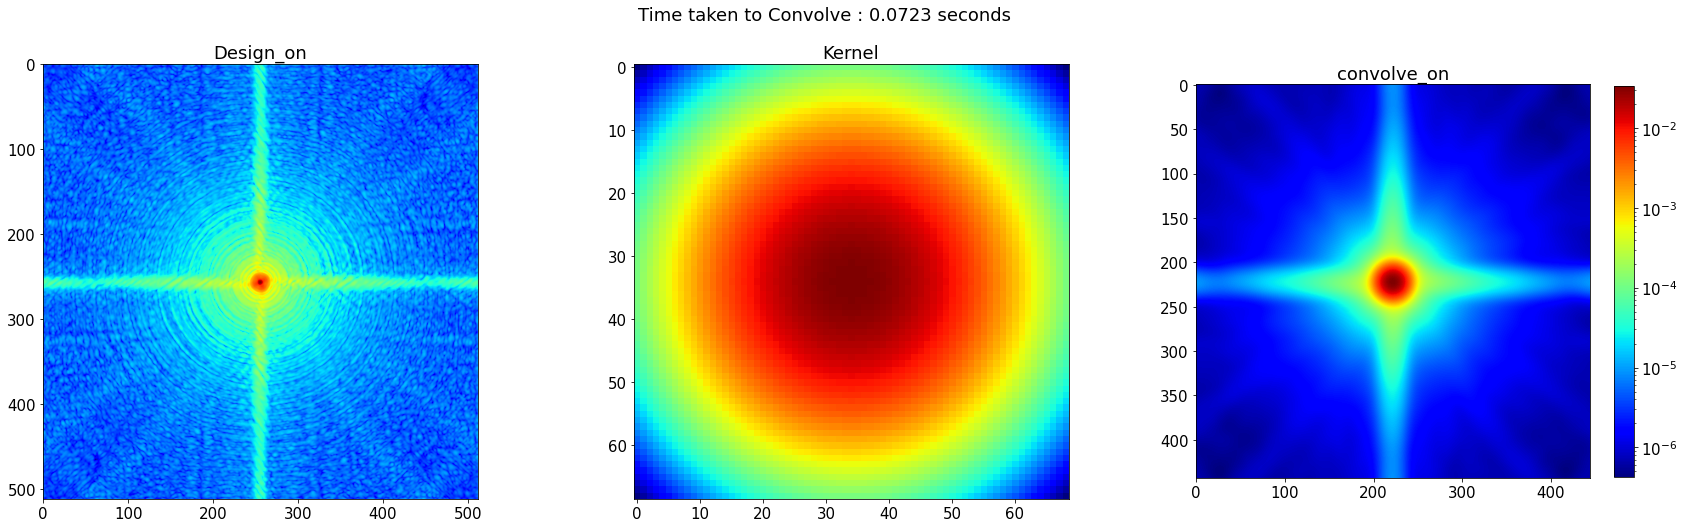

In [25]:
On_PSF = np.loadtxt("on_axis_nor.TXT") # Read PSF file
On_PSF = (0.75*On_PSF)/On_PSF.max()

fig, ax = plt.subplots(1,3, figsize = (30,8))
ax[0].set_title("Design_on")
ax[0].imshow(On_PSF, cmap="jet",norm=colors.LogNorm())

kernel = Gaussian2DKernel(sigma,sigma,x_size=69,y_size=69)
kernel.normalize()

data     = torch.tensor(On_PSF).unsqueeze(0).cuda()
kernel_t = torch.tensor(kernel.array).cuda()

start = perf_counter()
out = F.conv2d(Variable(data.view(1,1,512,512)),Variable(kernel_t.view(1,1,69,69))).squeeze().cpu().numpy()

stop  = perf_counter()- start

ax[1].set_title("Kernel")
ax[1].imshow(kernel, cmap="jet",norm=colors.LogNorm())

ax[2].set_title("convolve_on")
im_on = ax[2].imshow(out, cmap="jet",norm=colors.LogNorm())
plt.colorbar(im_on,shrink=0.9)
fig.suptitle(f"Time taken to Convolve : {np.round(stop,4)} seconds");

### **Using Astropy**

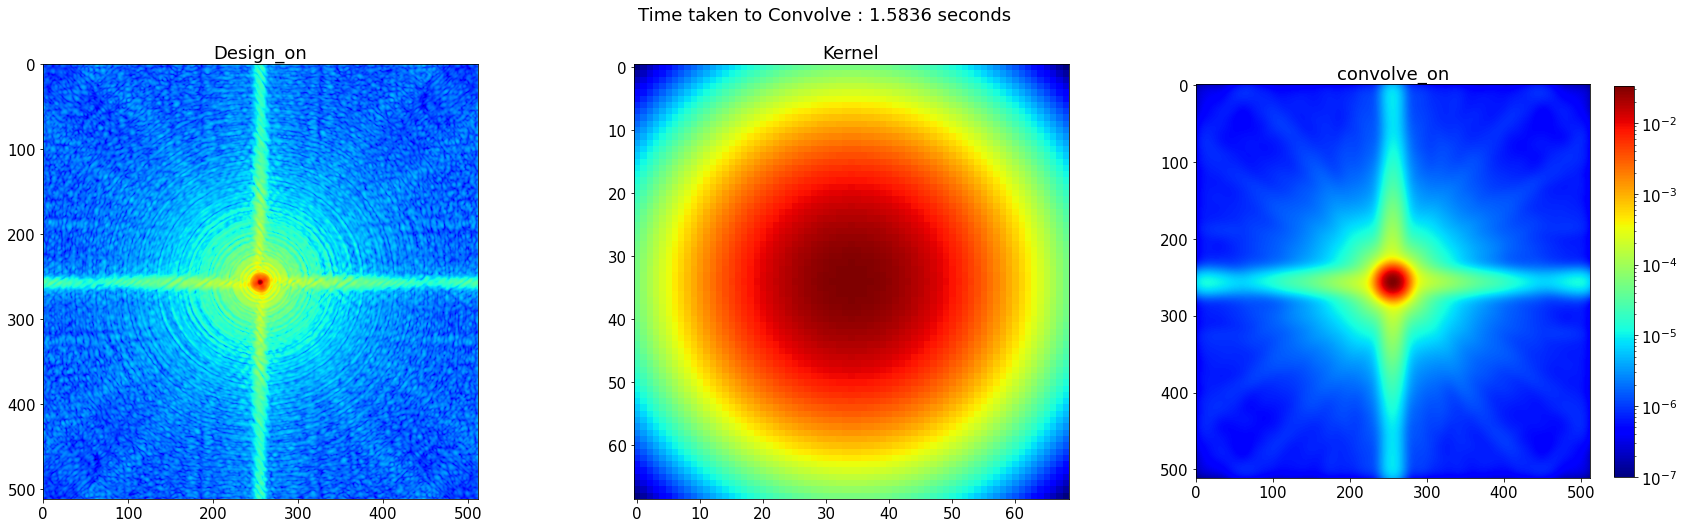

In [201]:
On_PSF = np.loadtxt("on_axis_nor.TXT") # Read PSF file
On_PSF = (0.75*On_PSF)/On_PSF.max()

fig, ax = plt.subplots(1,3, figsize = (30,8))
ax[0].set_title("Design_on")
ax[0].imshow(On_PSF, cmap="jet",norm=colors.LogNorm())

kernel = Gaussian2DKernel(sigma,sigma,x_size=69,y_size=69)
kernel.normalize()
start = perf_counter()
astropy_conv_on = convolve(On_PSF, kernel) # Astropy convolution

stop  = perf_counter()- start

ax[1].set_title("Kernel")
ax[1].imshow(kernel, cmap="jet",norm=colors.LogNorm())

ax[2].set_title("convolve_on")
im_on = ax[2].imshow(astropy_conv_on, cmap="jet",norm=colors.LogNorm())
plt.colorbar(im_on,shrink=0.9)
fig.suptitle(f"Time taken to Convolve : {np.round(stop,4)} seconds");

### **FWHM**

In [202]:
dist, FWHM = fwhm_pixel_dist(astropy_conv_on)
FWHM

21.730296008968917

In [203]:
s = FWHM*gaussian_fwhm_to_sigma
s

9.228007063564519

In [205]:
print("FWHM          : {}\nPeak position : {}".format(s*gaussian_sigma_to_fwhm, np.where(astropy_conv_on==astropy_conv_on.max())))

FWHM          : 21.730296008968917
Peak position : (array([256]), array([255]))


### **Photometry**

Flux inside 3 sigma radius

In [208]:
positions  = [(256,255)]
aperture   = phot.aperture.CircularAperture(positions, r=s*3)
data       = astropy_conv_on
phot_table = aperture_photometry(data, aperture)
phot_table['fraction'] = phot_table['aperture_sum']/astropy_conv_off.sum()
phot_table

id,xcenter,ycenter,aperture_sum,fraction
,pix,pix,,
int64,float64,float64,float64,float64
1,256.0,255.0,18.482006075357408,0.7988118920139913


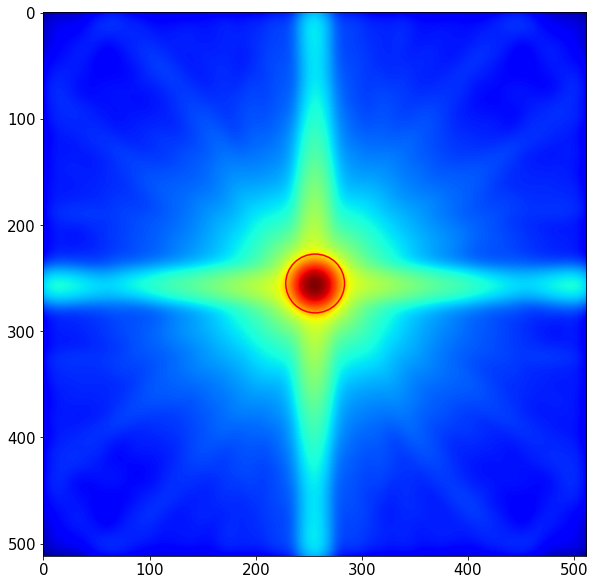

In [209]:
fig,ax = plt.subplots(1)
ax.imshow(data, cmap = 'jet',norm=colors.LogNorm())
aperture.plot(axes=ax, color='red', lw=1.5)

In [210]:
positions   = [(256,255)]
n           = 15
aperture    = [phot.aperture.CircularAperture(positions, r=s+s*i) for i in range(n)]
data_on     = 0.89*astropy_conv_on/astropy_conv_on.sum()
phot_table  = aperture_photometry(data_on, aperture)
phot_table

id,xcenter,ycenter,aperture_sum_0,aperture_sum_1,aperture_sum_2,aperture_sum_3,aperture_sum_4,aperture_sum_5,aperture_sum_6,aperture_sum_7,aperture_sum_8,aperture_sum_9,aperture_sum_10,aperture_sum_11,aperture_sum_12,aperture_sum_13,aperture_sum_14
,pix,pix,,,,,,,,,,,,,,,
int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
1,256.0,255.0,0.3023465766229711,0.6735976439515129,0.7922339052636899,0.8207769426266365,0.834366554654611,0.8438875092620673,0.8511923354027059,0.8569948478598475,0.861670305684112,0.8654965210387517,0.8686413097612765,0.8712485538884975,0.8734349881701354,0.8753027466156577,0.8769220156949311


In [211]:
flux_on = np.array([phot_table[f'aperture_sum_{i}'].value[0] for i in range(15)])
sigma = [i for i in range(1,1+n)]

Text(0, 0.5, 'Flux')

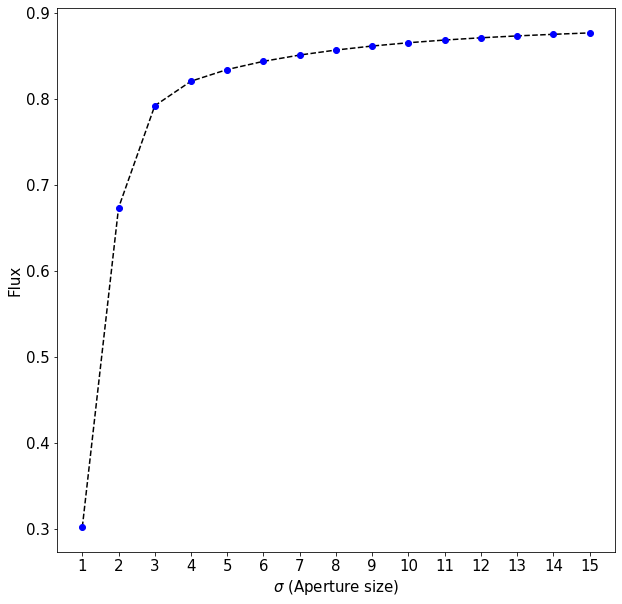

In [212]:
plt.plot(sigma,flux_on, markeredgecolor='blue',markerfacecolor='blue',color='black', marker='o', linestyle='dashed')
plt.xticks(sigma)
plt.xlabel(r'$\sigma$ (Aperture size)')
plt.ylabel('Flux')

In [213]:
cen_i, cen_j = np.where(data_on == data_on.max())
cen_i, cen_j = cen_i[0], cen_j[0]
cen_i, cen_j

(256, 255)

In [214]:
data_on[cen_i, cen_j]

0.001456259955485339

In [215]:
on_esf = []
on_x   = np.arange(0,100,1)
for i in on_x:
  fl = data_on[cen_j-i:cen_j + i+1,cen_i-i:cen_i+i+1]
  on_esf.append(fl.sum())

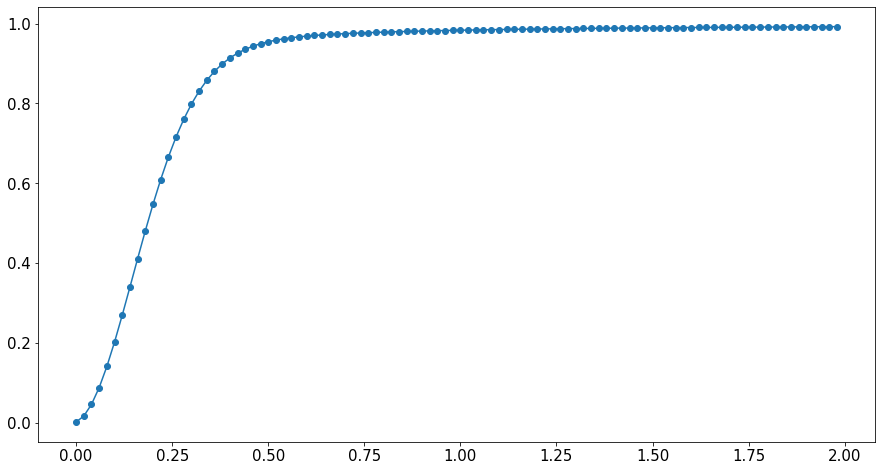

In [216]:
plt.figure(figsize=(15,8))
plt.plot(off_x*0.02,off_esf,'o-')


##  **Comparison**

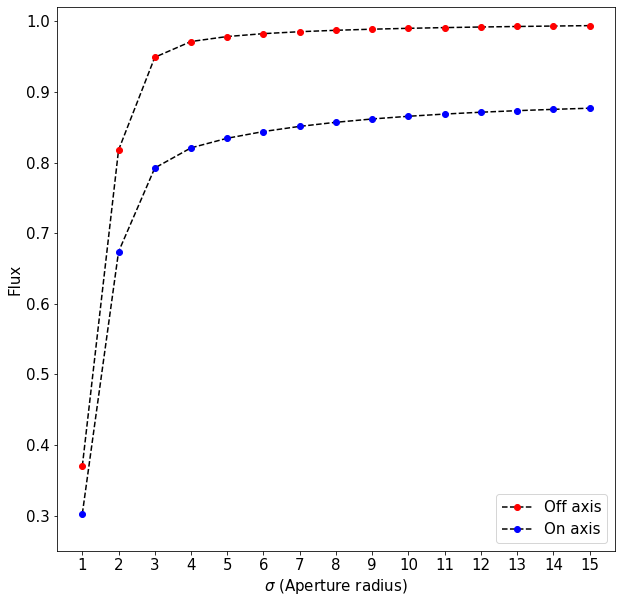

In [217]:
plt.plot(sigma,flux_off, markeredgecolor='red',markerfacecolor='red',color='black', marker='o', linestyle='dashed')
plt.plot(sigma,flux_on, markeredgecolor='blue',markerfacecolor='blue',color='black', marker='o', linestyle='dashed')
plt.xticks(sigma)
plt.xlabel(r'$\sigma$ (Aperture radius)')
plt.ylabel('Flux')
plt.ylim(0.25,1.02)
plt.legend(['Off axis','On axis'])

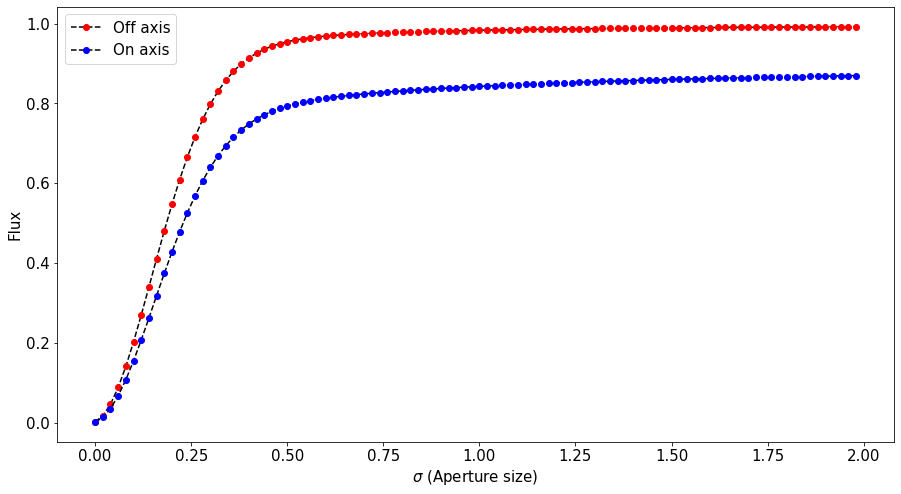

In [121]:
plt.figure(figsize=(15,8))
plt.plot(off_x*0.02,off_esf, markeredgecolor='red',markerfacecolor='red',color='black', marker='o', linestyle='dashed')
plt.plot(on_x*0.02,on_esf, markeredgecolor='blue',markerfacecolor='blue',color='black', marker='o', linestyle='dashed')
plt.xlabel(r'$\sigma$ (Aperture size)')
plt.ylabel('Flux')
plt.legend(['Off axis','On axis'])

# **Binning**

## **Off-axis**

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log10
  # Remove the CWD from sys.path while we load stuff.


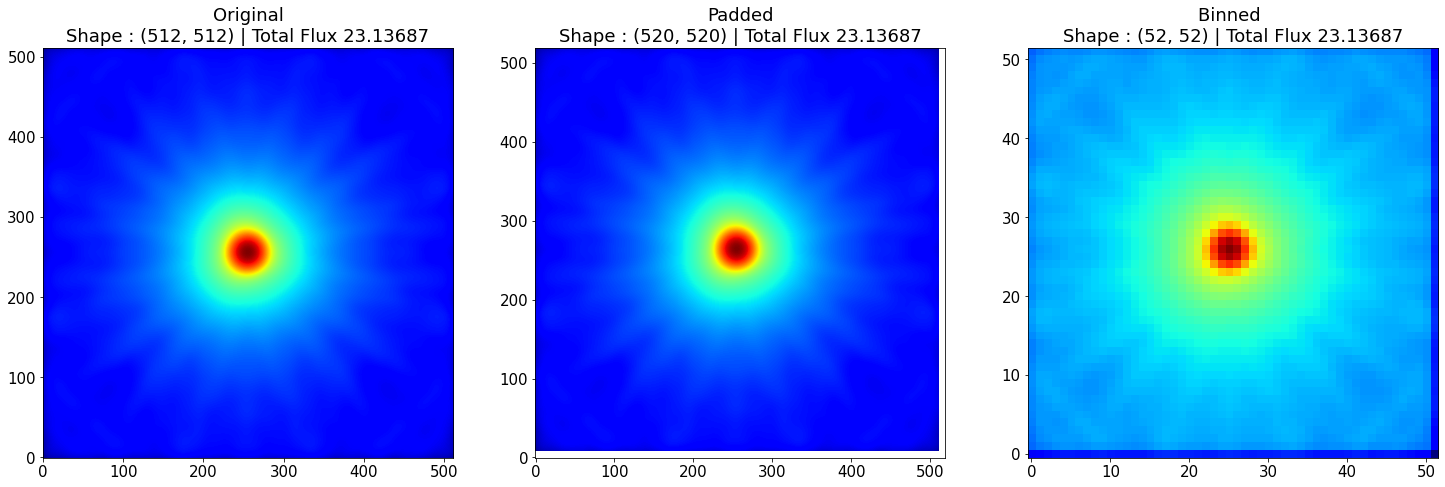

In [218]:
Flux = astropy_conv_off    #Off_PSF
Flux_p = np.pad(Flux,((8,0),(0,8)),mode='constant')
Flux_b_off = Flux_p.reshape(52,10, 52,10).sum(axis=(3,1))

fig, ax = plt.subplots(1,3,figsize=(25,10))

ax[0].imshow(np.log10(Flux/Flux.max()),origin = 'lower',cmap='jet')
ax[0].set_title('Original\nShape : {shape} | Total Flux {number:.{digits}f}'.format(shape = Flux.shape,number=Flux.sum(), digits=5))

ax[1].imshow(np.log10(Flux_p/Flux_p.max()),origin = 'lower',cmap='jet')
ax[1].set_title('Padded\nShape : {shape} | Total Flux {number:.{digits}f}'.format(shape = Flux_p.shape,number=Flux_p.sum(), digits=5))

ax[2].imshow(np.log10(Flux_b_off/Flux_b_off.max()),origin = 'lower',cmap='jet')
ax[2].set_title('Binned \nShape : {shape} | Total Flux {number:.{digits}f}'.format(shape = Flux_b_off.shape,number=Flux_b_off.sum(), digits=5));

### **FWHM**

In [259]:
Flux_b_off.max()/Flux_b_off.sum()

0.17084376140617666

In [260]:
dist, FWHM = fwhm_pixel_dist(Flux_b_off, r_frac_min=0.2,r_frac_max=0.2)
FWHM

2.0

In [261]:
init = models.Gaussian2D()

fit  = fitting.SLSQPLSQFitter()

y,x = np.mgrid[-26:26,-26:26]/26

model = fit(init,x,y,Flux_b_off)
model

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.008486204693234809
            Iterations: 67
            Function evaluations: 612
            Gradient evaluations: 65


<Gaussian2D(amplitude=3.93081791, x_mean=-0.03812156, y_mean=-0.00134359, x_stddev=0.0364161, y_stddev=0.0364717, theta=0.37493198)>

In [262]:
arr_scale = 2/52

In [263]:
sx = model.x_stddev/arr_scale
sy = model.y_stddev/arr_scale

sx, sy

(0.9468186780895007, 0.9482641238519354)

In [264]:
print("FWHM_x        : {} \nFWHM_y        : {}\nPeak position : {}".format(sx*gaussian_sigma_to_fwhm, sy*gaussian_sigma_to_fwhm, np.where(Flux_b_off==Flux_b_off.max())))

FWHM_x        : 2.229587602174862 
FWHM_y        : 2.232991366830248
Peak position : (array([26]), array([25]))


In [265]:
Flux_b_off.max()/Flux_b_off.sum()

0.17084376140617666

In [266]:
sx

0.9468186780895007

### **Photometry**

In [267]:
positions              = [(25,26)]
aperture               = phot.aperture.CircularAperture(positions, r=3*sx)
data_b_off             = Flux_b_off/Flux_b_off.sum()
phot_table             = aperture_photometry(data_b_off, aperture)
phot_table

id,xcenter,ycenter,aperture_sum
,pix,pix,
int64,float64,float64,float64
1,25.0,26.0,0.9498666057401155


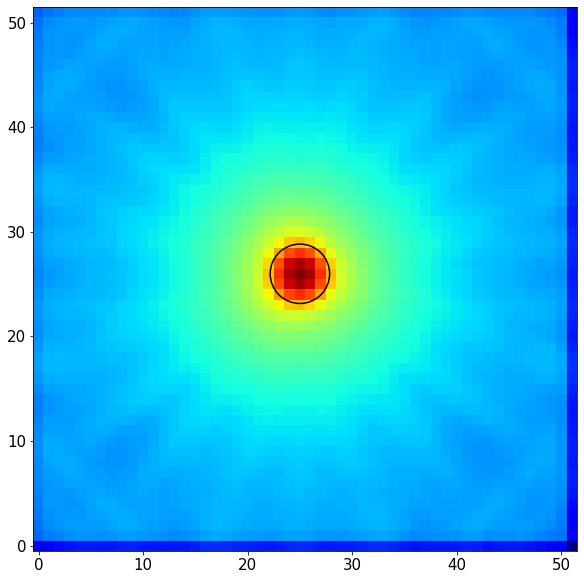

In [268]:
fig,ax = plt.subplots(1)
ax.imshow(data, cmap = 'jet',norm=colors.LogNorm(),origin='lower')
aperture.plot(axes=ax, color='black', lw=1.5)

In [301]:
positions   = [(25,26)]
n           = 40
aperture    = [phot.aperture.CircularAperture(positions, r=0.5*i) for i in range(1,n)]
data_b_off  = Flux_b_off/Flux_b_off.sum()
phot_table  = aperture_photometry(data_b_off, aperture)
phot_table

id,xcenter,ycenter,aperture_sum_0,aperture_sum_1,aperture_sum_2,aperture_sum_3,aperture_sum_4,aperture_sum_5,aperture_sum_6,aperture_sum_7,aperture_sum_8,aperture_sum_9,aperture_sum_10,aperture_sum_11,aperture_sum_12,aperture_sum_13,aperture_sum_14,aperture_sum_15,aperture_sum_16,aperture_sum_17,aperture_sum_18,aperture_sum_19,aperture_sum_20,aperture_sum_21,aperture_sum_22,aperture_sum_23,aperture_sum_24,aperture_sum_25,aperture_sum_26,aperture_sum_27,aperture_sum_28,aperture_sum_29,aperture_sum_30,aperture_sum_31,aperture_sum_32,aperture_sum_33,aperture_sum_34,aperture_sum_35,aperture_sum_36,aperture_sum_37,aperture_sum_38
,pix,pix,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
1,25.0,26.0,0.13418037643632302,0.36532157623597655,0.6683994473361522,0.8308673698598547,0.921629336820949,0.9554526336534471,0.9688324819874905,0.9746008118921731,0.9782567531375551,0.9807796740186394,0.9828209364131895,0.9844037881369223,0.9857616160027803,0.9868728541295284,0.9878513679831151,0.9886815895364106,0.9894289007096049,0.9900784750025181,0.9906722236101361,0.9911979878774577,0.9916836859218829,0.9921206133198817,0.9925285912801804,0.9929025888944273,0.9932560584920374,0.9935854328088254,0.9938998299896195,0.9941956729587165,0.994478962579403,0.994747229462811,0.9950053717886483,0.9952505577464685,0.9954883690944253,0.9957166142478464,0.9959393416971621,0.9961556826593656,0.9963669094612866,0.9965734395738466,0.9967750151320116


In [305]:
flux_b_off = [phot_table[f'aperture_sum_{i}'].value[0] for i in range(n-1)]
sigma = np.array([i for i in range(1,n)])*0.1

Text(0, 0.5, 'Flux')

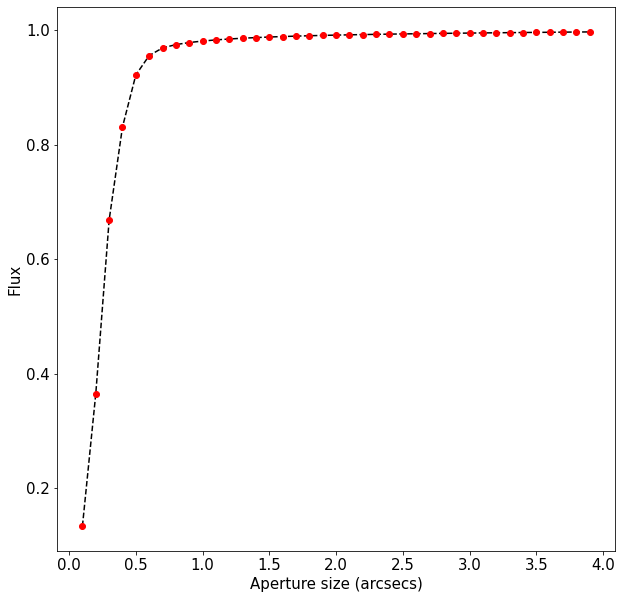

In [306]:
plt.plot(sigma,flux_b_off, markeredgecolor='red',markerfacecolor='red',color='black', marker='o', linestyle='dashed')
plt.xlabel(r'Aperture size (arcsecs)')
plt.ylabel('Flux')

In [310]:
off_esf = []
off_x   = np.arange(0,20,1)
for i in off_x:
  fl = data_b_off[cen_i-i:cen_i + i+1,cen_j-i:cen_j+i+1]
  off_esf.append(fl.sum())
off_aper = np.array([(2*i+1)*0.1 for i in off_x])

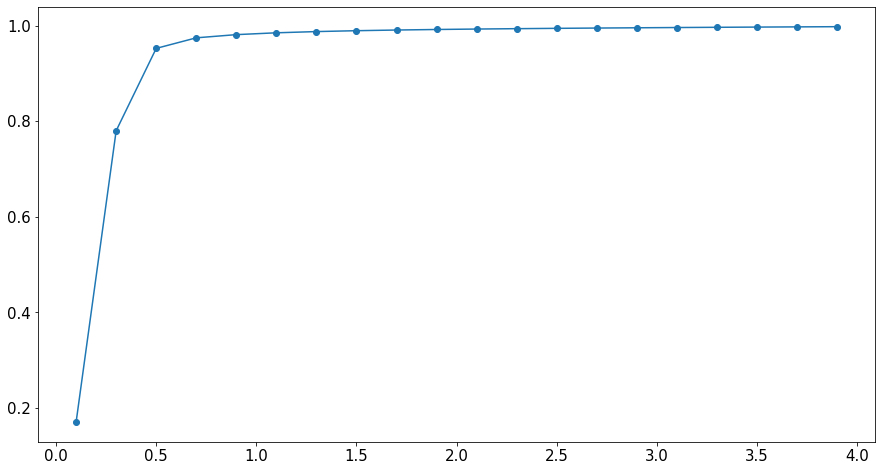

In [311]:
plt.figure(figsize=(15,8))
plt.plot(off_aper,off_esf,'o-')

## **On-axis**

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log10
  # Remove the CWD from sys.path while we load stuff.


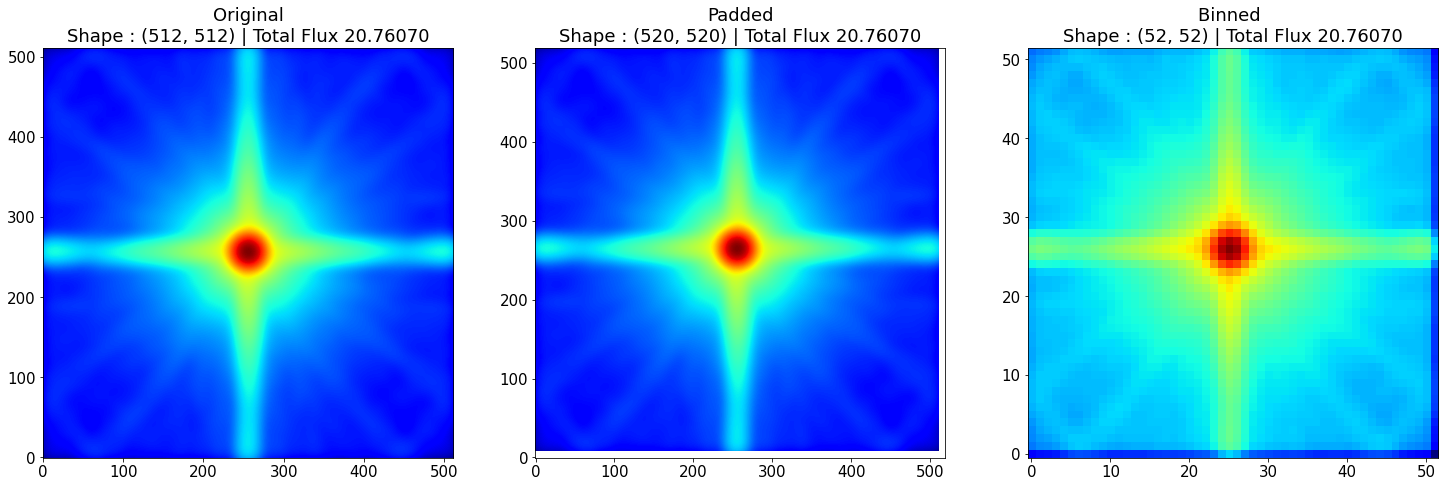

In [292]:
Flux = astropy_conv_on
Flux_p = np.pad(Flux,((8,0), (0,8)),mode='constant')
Flux_b_on = Flux_p.reshape(52,10, 52,10).sum(axis=3).sum(axis=1)

fig, ax = plt.subplots(1,3,figsize=(25,10))

ax[0].imshow(np.log10(Flux/Flux.max()),origin = 'lower',cmap='jet')
ax[0].set_title('Original\nShape : {shape} | Total Flux {number:.{digits}f}'.format(shape = Flux.shape,number=Flux.sum(), digits=5))

ax[1].imshow(np.log10(Flux_p/Flux_p.max()),origin = 'lower',cmap='jet')
ax[1].set_title('Padded\nShape : {shape} | Total Flux {number:.{digits}f}'.format(shape = Flux_p.shape,number=Flux_p.sum(), digits=5))

ax[2].imshow(np.log10(Flux_b_on/Flux_b_on.max()),origin = 'lower',cmap='jet')
ax[2].set_title('Binned \nShape : {shape} | Total Flux {number:.{digits}f}'.format(shape = Flux_b_on.shape,number=Flux_b_on.sum(), digits=5));

### **FWHM**

In [293]:
dist, FWHM = fwhm_pixel_dist(Flux_b_on, r_frac_min=0.2,r_frac_max=0.2)
FWHM

2.0

In [294]:
s  = FWHM*gaussian_fwhm_to_sigma
s

0.8493218002880191

In [295]:
positions  = [(25,26)]
aperture   = phot.aperture.CircularAperture(positions, r=3)
data       = Flux_b_on
phot_table = aperture_photometry(data, aperture)
phot_table['fraction'] = phot_table['aperture_sum']/data.sum()
phot_table

id,xcenter,ycenter,aperture_sum,fraction
,pix,pix,,
int64,float64,float64,float64,float64
1,25.0,26.0,18.581810834677615,0.8950474191507625


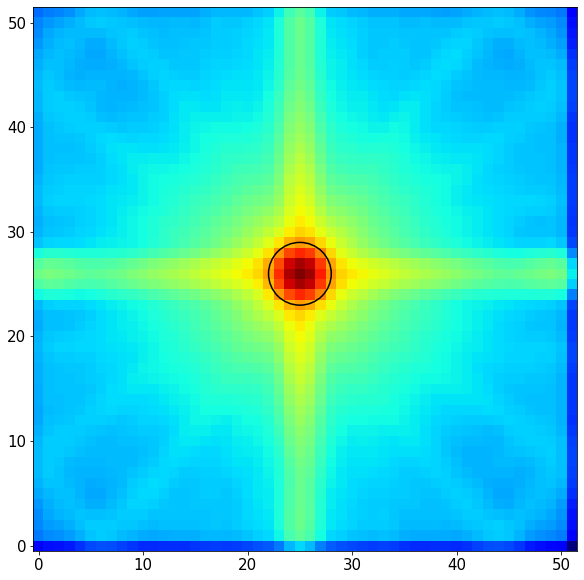

In [296]:
fig,ax = plt.subplots(1)
ax.imshow(data, cmap = 'jet',norm=colors.LogNorm(),origin='lower')
aperture.plot(axes=ax, color='black', lw=1.5)

In [297]:
Flux_b_on.max()/Flux_b_on.sum()

0.1478969478001307

### **Photometry**

In [333]:
positions   = [(25,26)]
n           = 40
aperture    = [phot.aperture.CircularAperture(positions, r=0.5*i) for i in range(1,n)]
data_b_on   = 0.89*Flux_b_on/Flux_b_on.sum()
phot_table  = aperture_photometry(data_b_on, aperture)
phot_table

id,xcenter,ycenter,aperture_sum_0,aperture_sum_1,aperture_sum_2,aperture_sum_3,aperture_sum_4,aperture_sum_5,aperture_sum_6,aperture_sum_7,aperture_sum_8,aperture_sum_9,aperture_sum_10,aperture_sum_11,aperture_sum_12,aperture_sum_13,aperture_sum_14,aperture_sum_15,aperture_sum_16,aperture_sum_17,aperture_sum_18,aperture_sum_19,aperture_sum_20,aperture_sum_21,aperture_sum_22,aperture_sum_23,aperture_sum_24,aperture_sum_25,aperture_sum_26,aperture_sum_27,aperture_sum_28,aperture_sum_29,aperture_sum_30,aperture_sum_31,aperture_sum_32,aperture_sum_33,aperture_sum_34,aperture_sum_35,aperture_sum_36,aperture_sum_37,aperture_sum_38
,pix,pix,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
1,25.0,26.0,0.10338061214513675,0.28769464662051114,0.5333629375502899,0.6739290403701229,0.7598698920744771,0.7965922030441783,0.8149249077108384,0.8249553651118569,0.8324454291516528,0.8382228288539328,0.843287020455545,0.8474788475988945,0.8513055898616957,0.8545339693780236,0.8575304716418655,0.8600740674344978,0.8624617247906273,0.8645002676008061,0.8664286728529716,0.8680749508159782,0.8696415309219083,0.8709861503087677,0.8722726672334834,0.8733900011423301,0.8744646149534343,0.875413029306972,0.8763292838342884,0.8771425133381985,0.8779298236669695,0.8786253478490285,0.8792995403279943,0.8799026086020801,0.880491420266545,0.8810273503788615,0.8815524277904774,0.8820357285487394,0.8825107450540278,0.8829543236806205,0.8833906604310426


In [334]:
flux_b_on = [phot_table[f'aperture_sum_{i}'].value[0] for i in range(n-1)]
sigma = np.array([i for i in range(1,n)])*0.1

Text(0, 0.5, 'Flux')

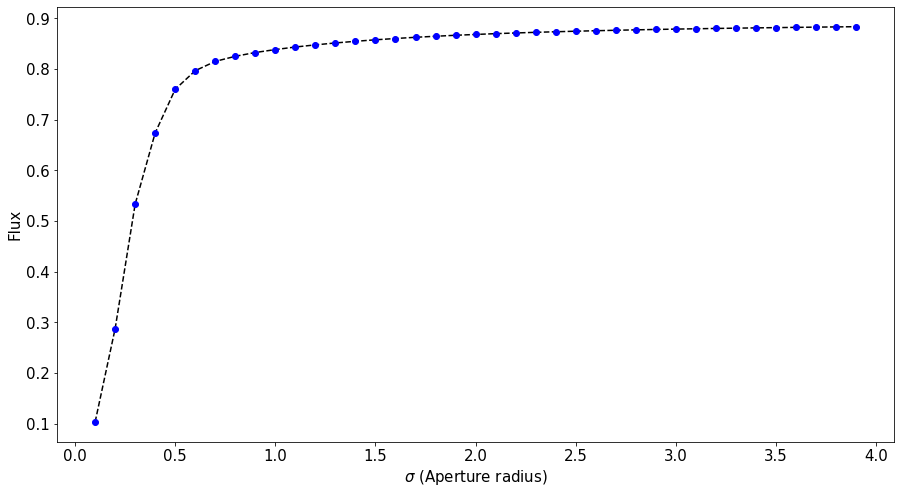

In [338]:
plt.figure(figsize=(15,8))
plt.plot(sigma,flux_b_on, markeredgecolor='blue',markerfacecolor='blue',color='black', marker='o', linestyle='dashed')
plt.xlabel(r'$\sigma$ (Aperture radius)')
plt.ylabel('Flux')

In [336]:
on_esf = []
on_x   = np.arange(0,20,1)
for i in on_x:
  fl = data_b_on[cen_i-i:cen_i + i+1,cen_j-i:cen_j+i+1]
  on_esf.append(fl.sum())

on_aper = np.array([(2*i+1)*0.1 for i in on_x])

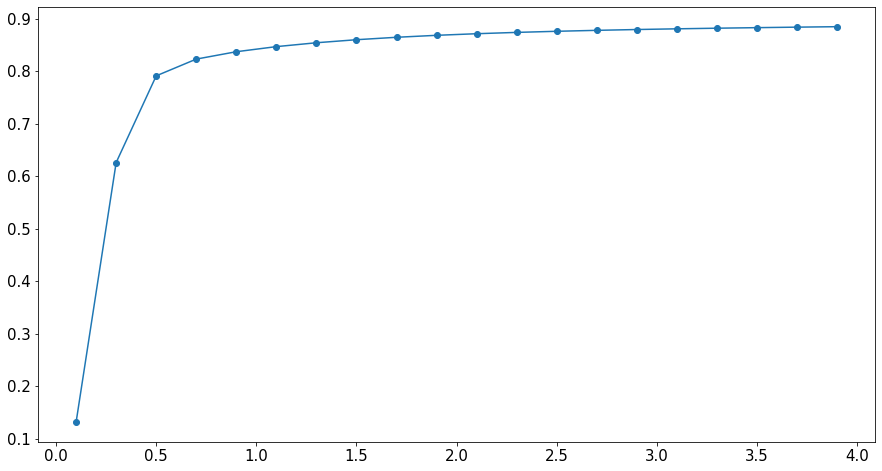

In [337]:
plt.figure(figsize=(15,8))
plt.plot(on_aper,on_esf,'o-')

Text(0.5, 1.0, 'Convolved | Binned')

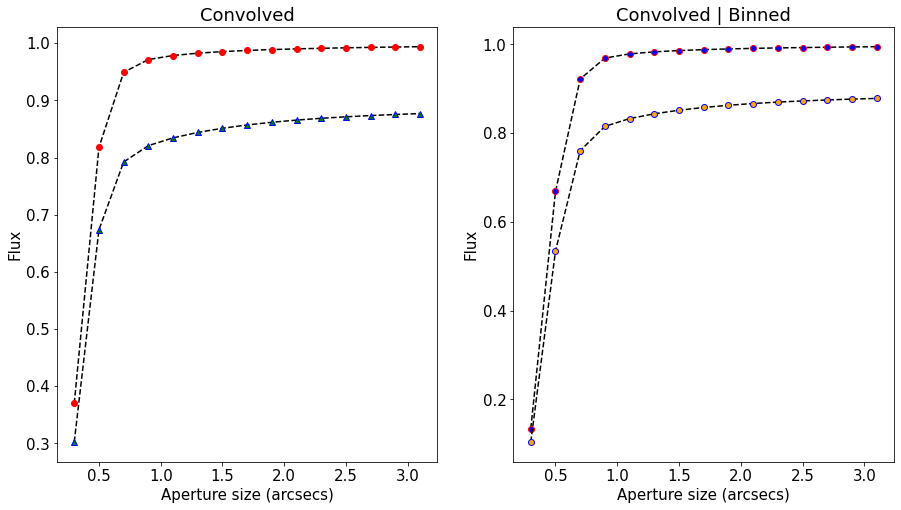

In [244]:
fig ,ax = plt.subplots(1,2,figsize=(15,8))
ax[0].plot(sigma*0.1,flux_off, markeredgecolor='red',markerfacecolor='red',color='black', marker='o', linestyle='dashed')
ax[0].plot(sigma*0.1,flux_on, markeredgecolor='blue',markerfacecolor='green',color='black', marker='^', linestyle='dashed')

ax[1].plot(sigma*0.1,flux_b_off, markeredgecolor='red',markerfacecolor='blue',color='black', marker='o', linestyle='dashed')
ax[1].plot(sigma*0.1,flux_b_on, markeredgecolor='blue',markerfacecolor='orange',color='black', marker='o', linestyle='dashed')

ax[0].set_xlabel(r'Aperture size (arcsecs)')
ax[0].set_ylabel('Flux')
ax[0].set_title('Convolved')

ax[1].set_xlabel(r'Aperture size (arcsecs)')
ax[1].set_ylabel('Flux')
ax[1].set_title('Convolved | Binned')

In [ ]:
plt.plot(sigma,flux_off, markeredgecolor='red',markerfacecolor='red',color='black', marker='o', linestyle='dashed')
plt.plot(sigma,flux_b_off, markeredgecolor='blue',markerfacecolor='blue',color='black', marker='^', linestyle='dashed')

plt.plot(sigma,flux_on, markeredgecolor='red',markerfacecolor='red',color='black', marker='.', linestyle='dashed')
plt.plot(sigma,flux_b_on, markeredgecolor='blue',markerfacecolor='blue',color='black', marker='*', linestyle='dashed')

plt.xticks(sigma)
plt.xlabel(r'$\sigma$ (Aperture size)')
plt.ylabel('Flux')

plt.legend(['Off axis', 'off axis binned','On axis', 'On axis binned'])

Text(0, 0.5, 'Flux Enclosed ')

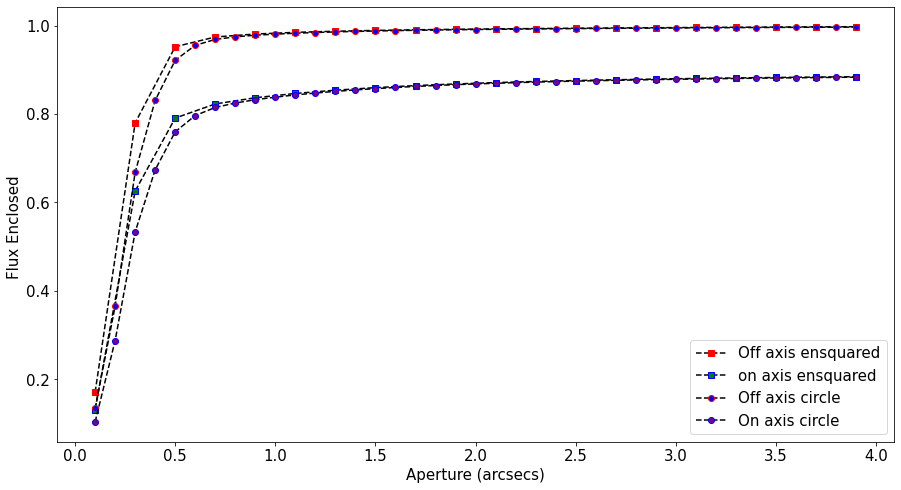

In [340]:
fig ,ax = plt.subplots(1,1,figsize=(15,8))
ax.plot(off_aper,off_esf, markeredgecolor='red',markerfacecolor='red',color='black', marker='s', linestyle='dashed')
ax.plot(on_aper,on_esf, markeredgecolor='blue',markerfacecolor='green',color='black', marker='s', linestyle='dashed')

ax.plot(sigma,flux_b_off, markeredgecolor='red',markerfacecolor='blue',color='black', marker='o', linestyle='dashed')
ax.plot(sigma,flux_b_on, markeredgecolor='blue',markerfacecolor='purple',color='black', marker='o', linestyle='dashed')
plt.legend(['Off axis ensquared','on axis ensquared','Off axis circle','On axis circle'])
plt.xlabel('Aperture (arcsecs)')
plt.ylabel('Flux Enclosed ')

# **Ellitpical fitting**

In [ ]:
surf = np.loadtxt('nominal6.txt',skiprows=1)

with open('nominal6.txt','r') as f:
  columns = f.readline()[1:-1].split('\t')
  f.close()
df = pd.DataFrame(surf, columns = columns )

In [ ]:
df

,X-Field,Y-Field,Sigma,e1,e2,EPS
0,-0.2500,-0.25,6.912,-0.001918,-0.000769,0.002066
1,-0.2339,-0.25,6.904,-0.001448,-0.000084,0.001451
2,-0.2177,-0.25,6.902,-0.001600,0.000234,0.001617
3,-0.2016,-0.25,6.904,-0.002247,0.000294,0.002266
4,-0.1855,-0.25,6.911,-0.003276,0.000188,0.003282
...,...,...,...,...,...,...
1019,0.1855,0.25,6.938,-0.007314,-0.000562,0.007336
1020,0.2016,0.25,6.943,-0.007774,-0.000671,0.007803
1021,0.2177,0.25,6.949,-0.008302,-0.000789,0.008339
1022,0.2339,0.25,6.955,-0.008883,-0.000908,0.008929


In [ ]:
x = df['X-Field'].values
y = df['X-Field'].values
z = df['Sigma'].values

In [ ]:
xx,yy = np.meshgrid(x[:32],y[:32])

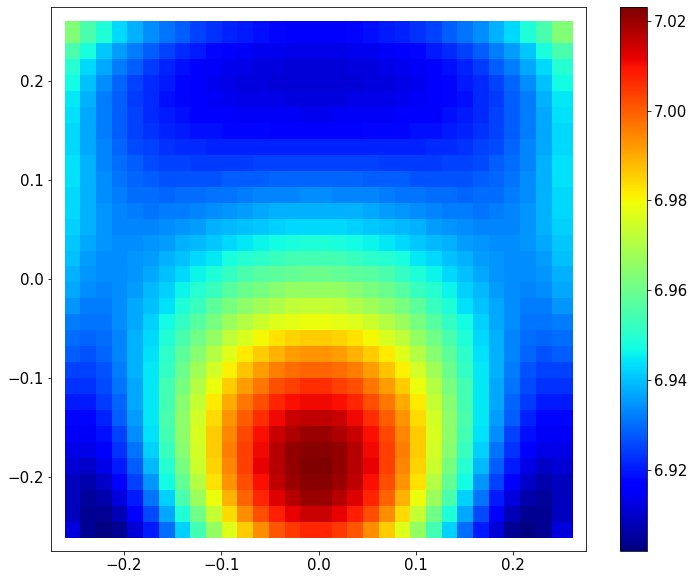

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(12,10))
img = ax.scatter(xx,yy,c=z.reshape(32,32), marker="s", s = (1500./fig.dpi)**2,cmap='jet')
plt.colorbar(img)

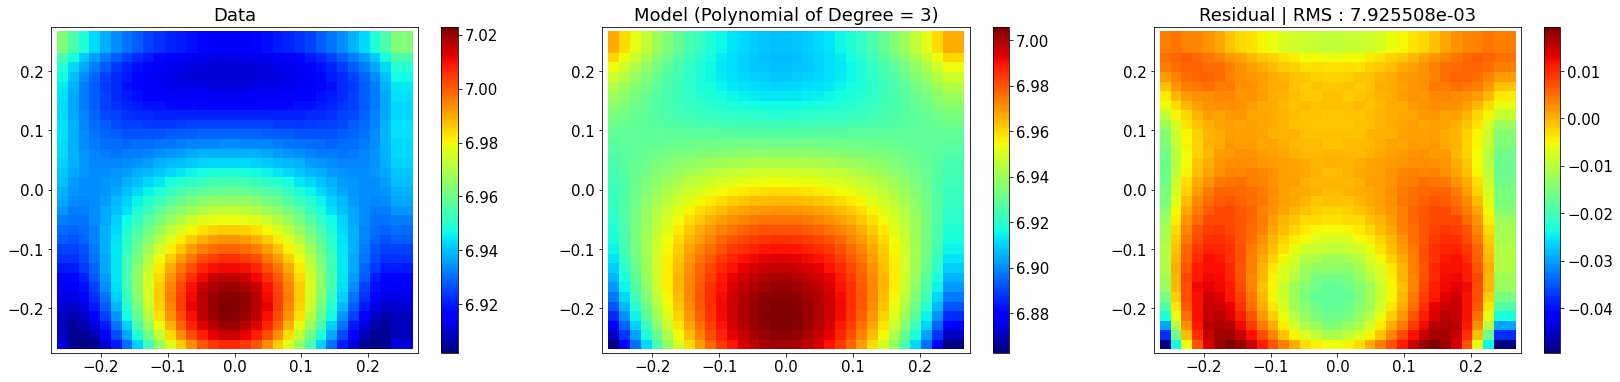

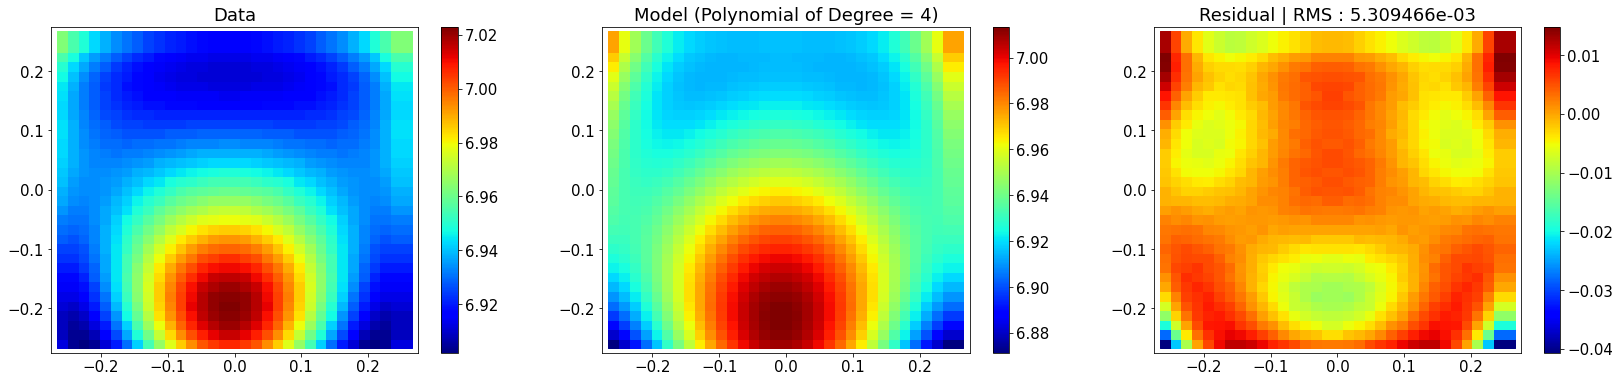

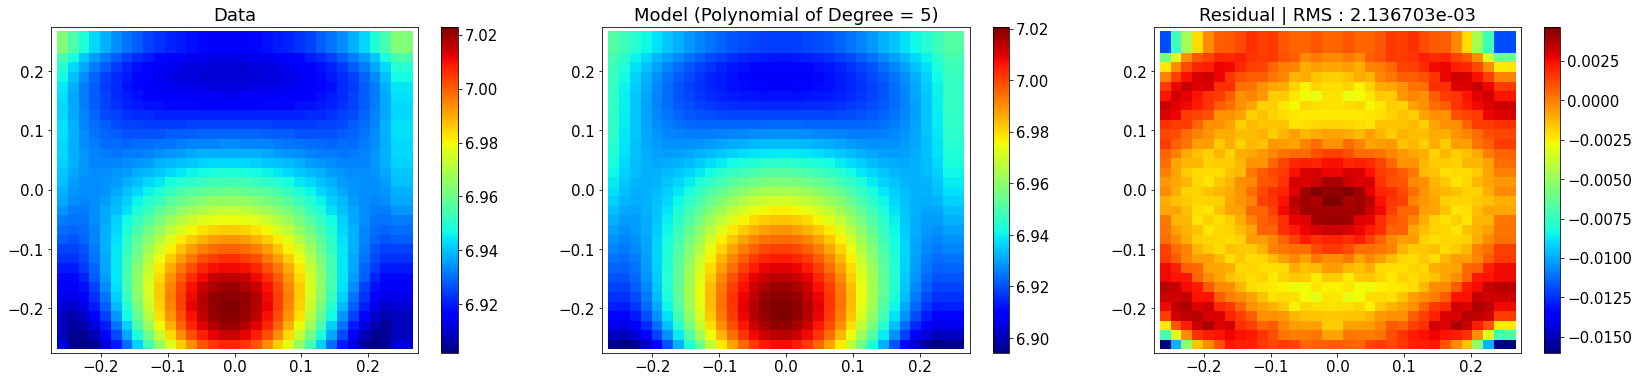

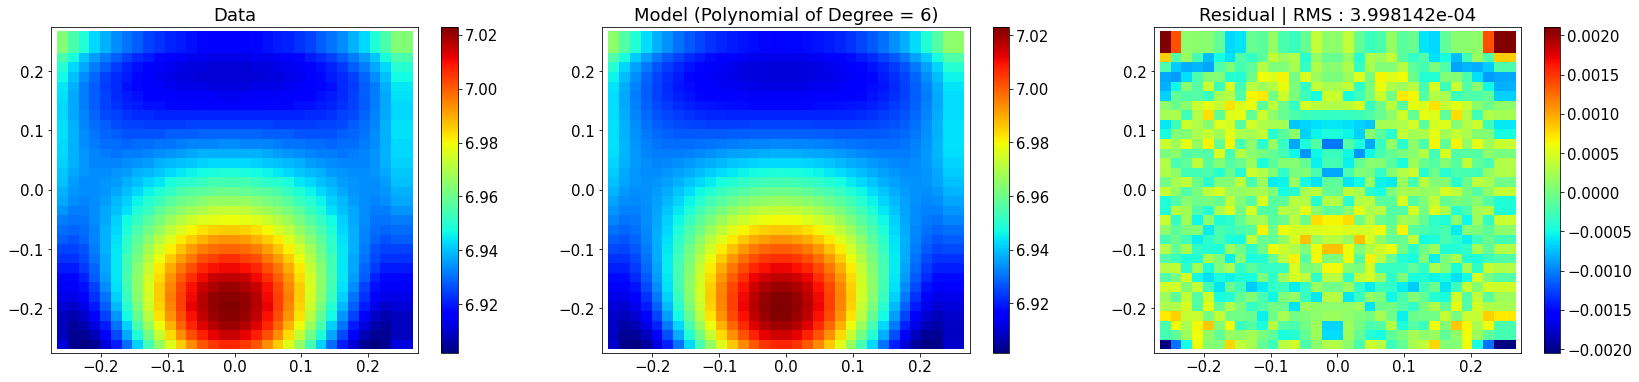

In [ ]:
for deg in [3,4,5,6]:
  init = models.Polynomial2D(deg)

  fit = fitting.LevMarLSQFitter()

  model = fit(init,x=xx,y=yy,z=z.reshape(32,32))
  fig, ax = plt.subplots(1,3,figsize=(28,6))
  resid = model(xx,yy)-z.reshape(32,32)

  img0 = ax[0].scatter(xx,yy,c = z.reshape(32,32) , marker="s", s = (1500./fig.dpi)**2,cmap='jet')
  plt.colorbar(img0, ax=ax[0])
  ax[0].set_title('Data')

  img1 = ax[1].scatter(xx,yy,c = model(xx,yy), marker="s", s = (1500./fig.dpi)**2,cmap='jet')
  plt.colorbar(img1, ax=ax[1])
  ax[1].set_title(f'Model (Polynomial of Degree = {deg})')

  img2 = ax[2].scatter(xx,yy,c = resid, marker="s", s = (1500./fig.dpi)**2,cmap='jet')
  plt.colorbar(img2, ax=ax[2])
  ax[2].set_title('Residual | RMS : {:e}'.format(np.sqrt(np.mean(resid**2))))

  plt.show()

# **SSR Code**


Design Flux_max,Flux_sum 0.033850291039145324 20.760699865833235
(520, 520)
3.070444144351318 20.76069986583323
Design Flux_max,Flux_sum 0.04362284719120173 23.134552939009946
(520, 520)
3.939135326348666 23.134552939009957
0.13162828354211634
0.6258866962351336
0.790956637840428
0.822845507255474
0.8368940582996435
0.8465969218083512
0.853976644153202
0.8597723464015459
0.8643959312714564
0.8681347310334813
0.8711843920549477
0.8737006778031655
0.8758120184957721
0.8776171711496319
0.8791738748448295
0.880514389686488
0.8816890214502164
0.8827381788772946
0.8836915778655351
0.8845784192074063
0.17027064826942973
0.7790376959737622
0.9520909545935005
0.9743076634943657
0.9809905798593525
0.9848251473999478
0.9873785756242133
0.9892214085832154
0.9906312112286522
0.9917549752508084
0.9926784280427605
0.9934618326211465
0.9941490308034837
0.9947654223440616
0.9953287452354199
0.9958483271683951
0.9963288996747433
0.9967772651056142
0.9972025344603539
0.997614111301701


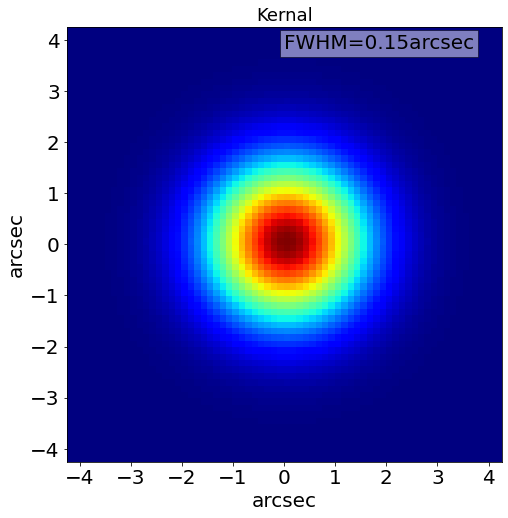

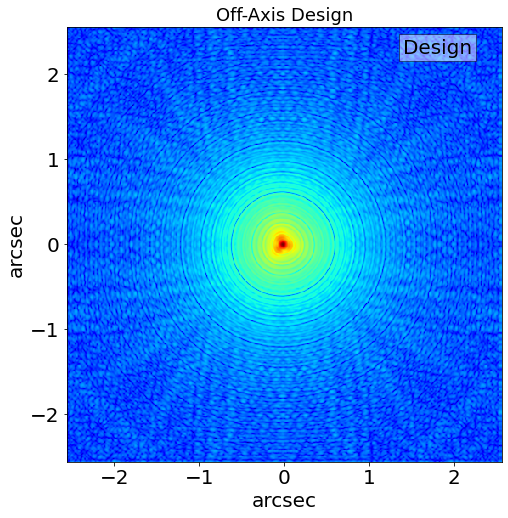

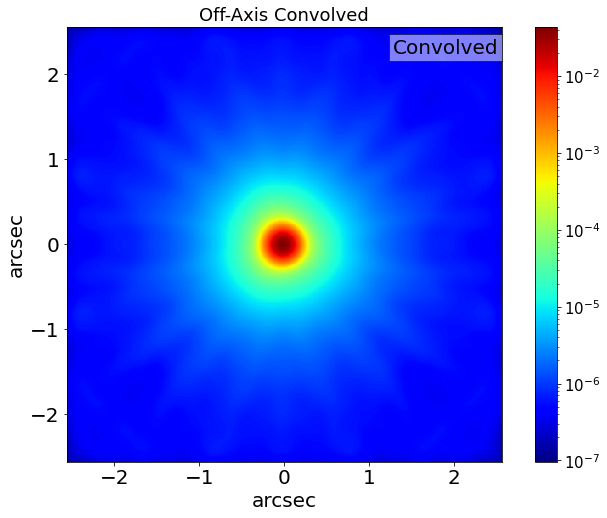

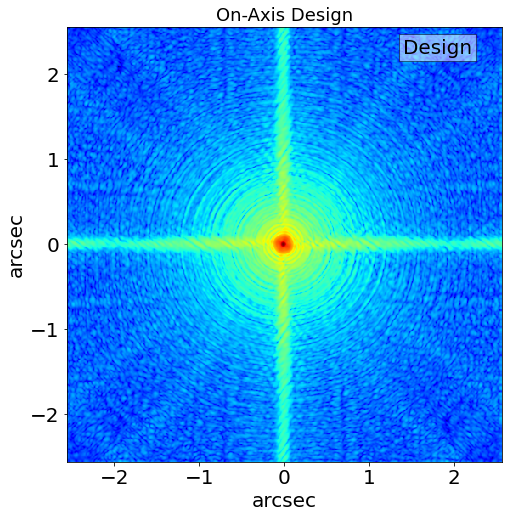

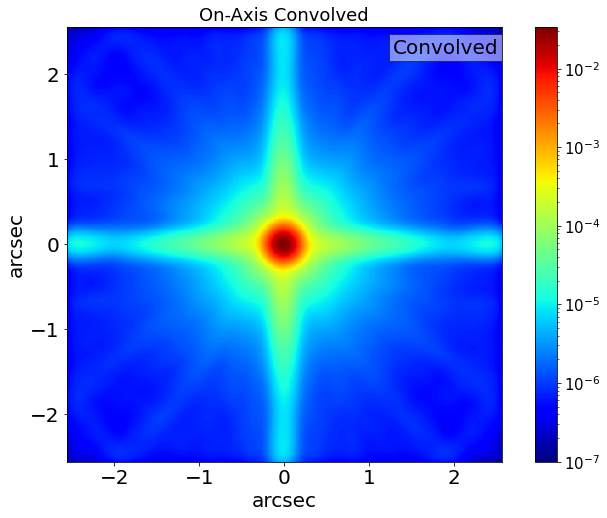

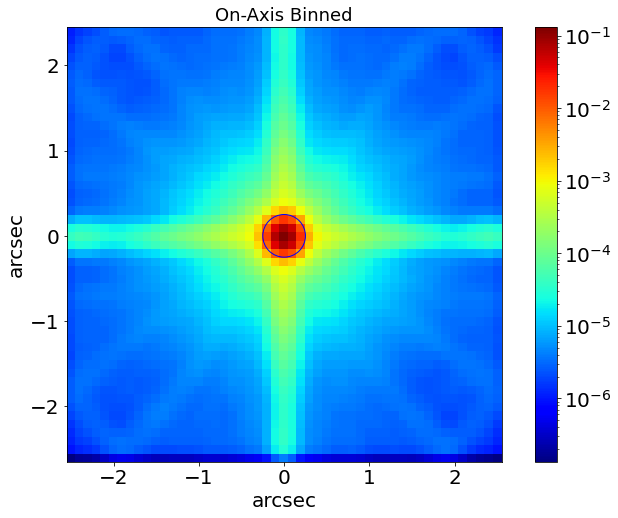

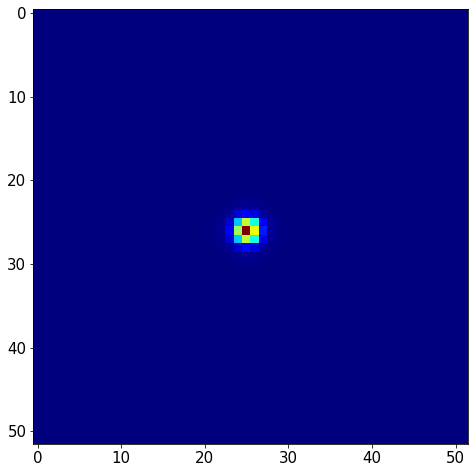

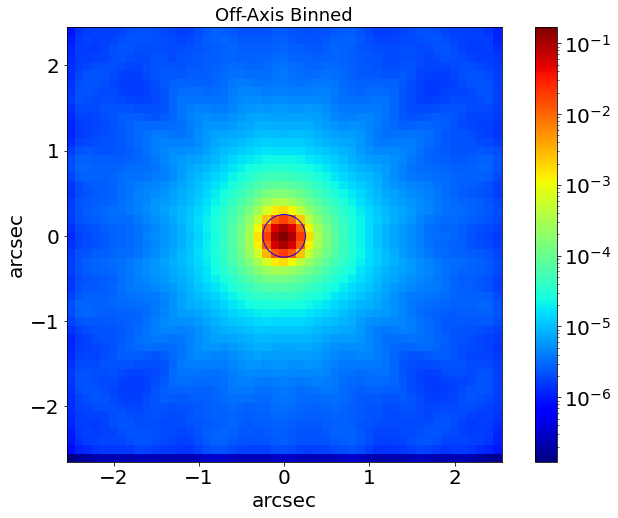

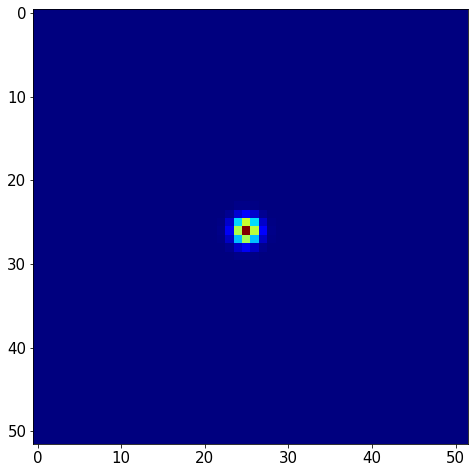

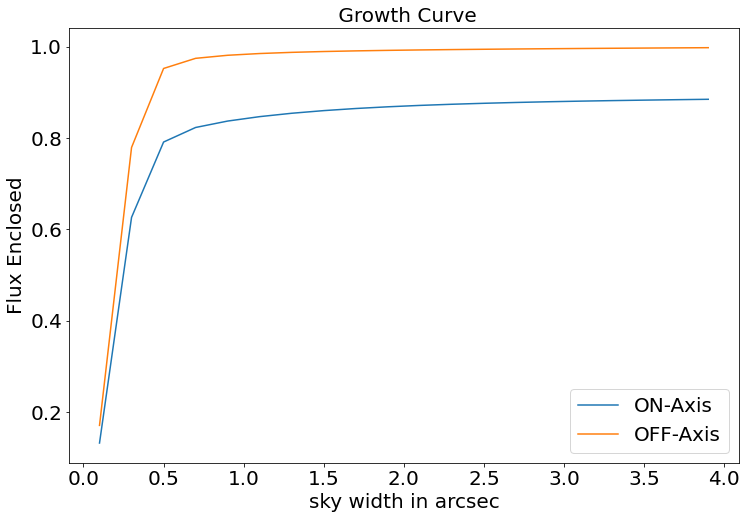

In [221]:
import numpy as np
from PIL import Image
from astropy.io import fits

import matplotlib.pyplot as plt
from astropy.visualization import astropy_mpl_style
from scipy import signal
import scipy.optimize as opt
from astropy.convolution import Gaussian2DKernel
from scipy.signal import convolve as scipy_convolve
from astropy.convolution import convolve
from matplotlib import colors
plt.close('all')

##########################################################################

#sz=100#130#130  # Huygens PSF image and pupil sampling 128x128 
#pixelSize = 1.0#1.0 #in microns
#fwhm=20/pixelSize
#SigmaInPix = fwhm/2.35#8.51/pixelSize  #4.6 8.51    5.27     #sigma of the gaussian in number of pixels(20 micron for 0.2arcsec)
#sigx=SigmaInPix
#sigy=sigx
Spatial=1 # 1um /unit
Datasize=512
FWHM=0.2
Sigma=FWHM/2.35 #=0.0638 " = 6.38units
# 1um coressponds to 0.01", 10um=0.1" this is plate scale of INSIST
# If FWHM=0.15" then Sigma would be 0.0638" which coressponds to 6.38units because 1unit is 0.01"
# So, give 6.38 units as Sigma in Kernal

kernel = Gaussian2DKernel(Sigma*100, x_size=69, y_size=69) # Why 6.38? please see above
ns=Sigma*100/2
xk=np.linspace(-ns,ns,69)
yk=xk
xk,yk=np.meshgrid(xk,yk)


fig=plt.figure("kernalx", figsize=(12,8))
ax = fig.add_subplot(111)
ax.set_aspect('equal')
ax.pcolormesh(xk,yk,kernel,cmap="jet" )
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel("arcsec",fontsize=20)
plt.ylabel("arcsec",fontsize=20)
plt.text(0.0,0.9*ns ,"FWHM=0.15arcsec",bbox=dict(facecolor='white', alpha=0.5), fontsize=20 )
plt.title("Kernal")


# ##################### OFF-AXIS Raw data display ##########################
XK=np.linspace(-2.56,2.56,513) # Why 513?
YK=XK
XK,YK=np.meshgrid(XK,YK)
Off_PSF = np.loadtxt("off_axis.TXT",skiprows=18,encoding='latin-1') # Red PSF txt file
img_off=Off_PSF
fig=plt.figure("Design_off", figsize=(12,8))
ax = fig.add_subplot(111)
ax.set_aspect('equal')
ax.pcolormesh(XK,YK,Off_PSF, cmap="jet",norm=colors.LogNorm())
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel("arcsec",fontsize=20)
plt.ylabel("arcsec",fontsize=20)
plt.text(1.4,2.25 ,"Design",bbox=dict(facecolor='white', alpha=0.5), fontsize=20 )
plt.title("Off-Axis Design")


# ############################## OFF-AXIS CONVOLUTION##################################

astropy_conv_off = signal.fftconvolve(img_off, kernel, mode="same")#convolve(img_off, kernel)


fig=plt.figure("convolve_off", figsize=(12,8))
ax = fig.add_subplot(111)
ax.set_aspect('equal')
im_off=ax.pcolormesh(XK,YK,astropy_conv_off, cmap="jet",norm=colors.LogNorm())
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel("arcsec",fontsize=20)
plt.ylabel("arcsec",fontsize=20)
plt.colorbar(im_off)
#circle1=plt.Circle((0,0), 0.25, color='b', fill=False)
#ax.add_patch(circle1)
plt.text(1.28,2.25 ,"Convolved",bbox=dict(facecolor='white', alpha=0.5), fontsize=20 )
plt.title("Off-Axis Convolved")



# ##################### ON-AXIS Raw data display ##########################
On_PSF=np.loadtxt("on_axis_nor.TXT")  # Read PSF file 
On_PSF=On_PSF*0.75 # Strehl:0.75
fig=plt.figure("Design_on", figsize=(12,8))
ax = fig.add_subplot(111)
ax.set_aspect('equal')
ax.pcolormesh(XK,YK,On_PSF, cmap="jet",norm=colors.LogNorm())
plt.text(1.4,2.25 ,"Design",bbox=dict(facecolor='white', alpha=0.5), fontsize=20 )
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel("arcsec",fontsize=20)
plt.ylabel("arcsec",fontsize=20)
plt.title("On-Axis Design")

# ############################## ON-AXIS CONVOLUTION##################################

astropy_conv_on = signal.fftconvolve(On_PSF, kernel, mode="same")#convolve(On_PSF, kernel)

fig=plt.figure("convolve_on", figsize=(12,8))
ax = fig.add_subplot(111)
ax.set_aspect('equal')
im_on=ax.pcolormesh(XK,YK,astropy_conv_on, cmap="jet",norm=colors.LogNorm())
plt.colorbar(im_on)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel("arcsec",fontsize=20)
plt.ylabel("arcsec",fontsize=20)
plt.text(1.28,2.25 ,"Convolved",bbox=dict(facecolor='white', alpha=0.5), fontsize=20 )
#circle1=plt.Circle((0,0), 0.25, color='b', fill=False)
#ax.add_patch(circle1)
plt.title("On-Axis Convolved")

DF=[]
for s in range (2):
    
# ###################### File selection for Binning ############################
#s=0 # 0- on axis, 1 off axis 

    if (s==0):
            Data=astropy_conv_on # on axis
            Nor=0.89 # Flux normalisation, for area
            plt_name="On-Axis Binned"
            plt_bin="On_axis_Binned"
            plt_image="On_axis_Binned_image"
    else:
            Data=astropy_conv_off # on axis
            plt_name="Off-Axis Binned"
            plt_bin="Off_axis_Binned"
            plt_image="Off_axis_Binned_image"
            Nor=1
    
    Flux_max=np.max(Data)
    Flux_sum=np.sum(Data)
    print ("Design Flux_max,Flux_sum", Flux_max,Flux_sum)
    
    # ######################################### 10x10 binning#####################
    
    Data=np.pad(Data, ((8,0), (0,8)), mode='constant')
    print(np.shape(Data))
    #plt.imshow(Data, cmap="jet") # RAW data after padding
    Data = Data.reshape(52,10 , 52,10)
    Data = Data.sum(axis=3).sum(axis=1) # BINNED
    #plt.imshow(Data, cmap="jet")# RAW data after padding and Bining
    
    print(np.max(Data), np.sum(Data))
    
    XB=np.linspace(-2.55,2.55,52)# (-2.52,2.52,57 a small adjustment made to center the PSF
    YB=np.linspace(-2.65,2.45,52)
    XB,YB=np.meshgrid(XB,YB)
    
    # ######################## Binned plot ##########################################
    
    fig=plt.figure(plt_bin, figsize=(12,8))
    ax = fig.add_subplot(111)
    ax.set_aspect('equal')
    DataF=Data/np.sum(Data) 
    DataF=DataF*Nor# for on axis  totla flux is normalised 
    Im=ax.pcolormesh(XB,YB,DataF, cmap="jet",norm=colors.LogNorm()) 
    P1=plt.colorbar(Im)
    P1.ax.tick_params(labelsize=20)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.xlabel("arcsec",fontsize=20)
    plt.ylabel("arcsec",fontsize=20)
    #plt.text(1.28,2.25 ,"Convolved",bbox=dict(facecolor='white', alpha=0.5), fontsize=20 )
    circle1=plt.Circle((0,0), 0.25, color='b', fill=False)
    ax.add_patch(circle1)
    plt.title(plt_name)
    
    fig=plt.figure(plt_image, figsize=(12,8))
    plt.imshow(DataF,cmap="jet")
    
    DF.append(DataF)


# Growth Curve ###########################
plt.figure("Growth", figsize=(12,8))
plt.title(" Growth Curve", fontsize=20)
plt.xlabel("sky width in arcsec", fontsize=20)
plt.ylabel("Flux Enclosed", fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
for k in range (2):
    if k==0:
        DD=DF[k] # on axis
        Label="ON-Axis"
    else:
        DD=DF[k] # off axis
        Label="OFF-Axis"

    xcl=26
    xcr=27
    ycl=25
    ycr=26
    Int_Flux=[]
    Aper=[]
    D=0.0
    for i in range (20):
        Di=np.sum(DD[xcl-i:xcr+i,ycl-i:ycr+i])
        Int_Flux.append(Di)
        aperture_size=(2*i+1)*0.1
        Aper.append(aperture_size)
        print ( Di)
    plt.plot(Aper,Int_Flux, label=Label)
    plt.legend(fontsize=20)

plt.show()

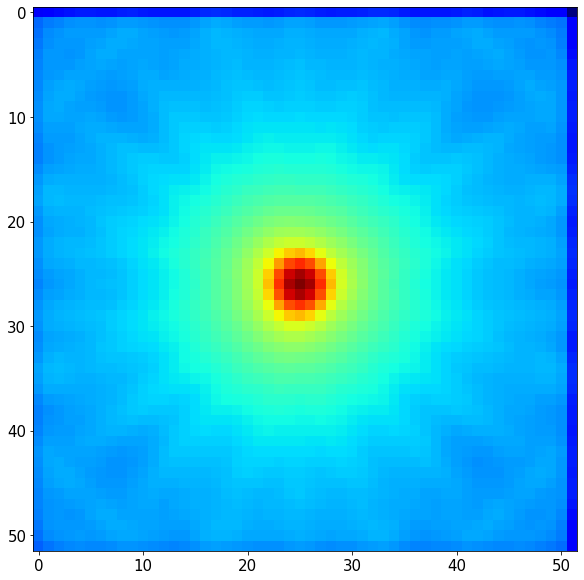

In [225]:
plt.imshow(DataF,cmap='jet',norm = colors.LogNorm())

In [227]:
DataF.max()/DataF.sum()

0.17027064826942975